# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.417219,False,2.156258
1,-0.847485,False,-1.501154
2,-1.096290,False,-3.909460
3,-2.918033,False,-4.763375
4,-0.909599,False,-1.312080
...,...,...,...
995,-1.268889,False,0.573991
996,0.211755,False,0.590996
997,-1.282191,True,1.327026
998,0.172696,True,3.401587


<Axes: xlabel='v0'>

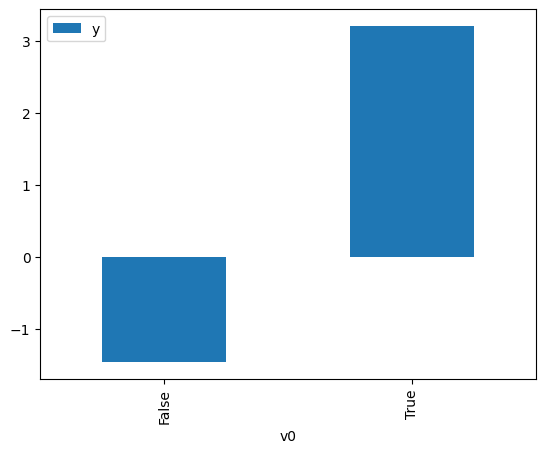

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

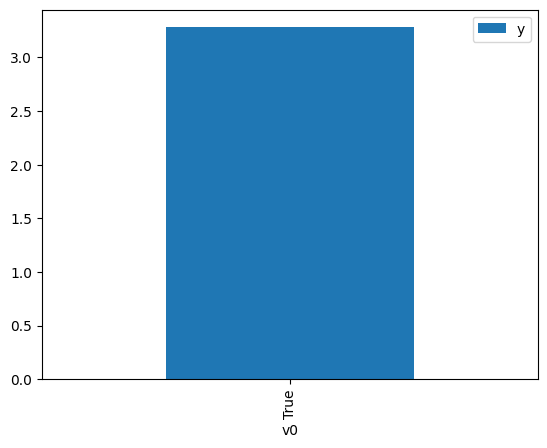

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.619612,False,-2.350378,0.874263,1.143821
1,-1.146063,False,-2.011275,0.794904,1.258014
2,-0.308756,False,-1.259694,0.579653,1.725169
3,-0.875800,False,-2.462851,0.735204,1.360167
4,-3.427753,False,-6.021539,0.984794,1.015440
...,...,...,...,...,...
995,-2.268617,False,-3.222198,0.939356,1.064559
996,-0.739078,False,-0.673569,0.701080,1.426370
997,0.987625,False,2.797127,0.217785,4.591682
998,-1.624353,False,-2.953172,0.874905,1.142982


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.368058,True,0.363669,0.054018,18.512387
1,-1.634183,True,1.653215,0.123773,8.079275
2,1.597115,True,8.499905,0.883998,1.131225
3,-0.137792,True,4.642764,0.472441,2.116668
4,-0.541894,True,4.757045,0.352268,2.838751
...,...,...,...,...,...
995,-1.180499,True,2.716059,0.198254,5.044030
996,0.238505,True,3.695748,0.587604,1.701826
997,0.379150,True,5.991471,0.628935,1.589989
998,-0.806167,True,3.005560,0.281861,3.547845


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              5530.
Date:                Sun, 30 Jul 2023   Prob (F-statistic):                        0.00
Time:                        09:46:28   Log-Likelihood:                         -1424.7
No. Observations:                1000   AIC:                                      2853.
Df Residuals:                     998   BIC:                                      2863.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6024      0.023     70.107      0.000       1.558       1.647
x2             4.9874      0.059     84.570      0.000       4.872       5.103
==============================================================================
Omnibus:                        6.502   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.631
Skew:                          -0.155   Prob(JB):                       0.0363
Kurtosis:                       3.250   Cond. No.                         2.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""